## Hawkeye Data Science Project

I will start by considering just one game that Gloucestershire Men's Team have played. To extend on this project, one could consider every Gloucestershire Men's games and perform a more extensive analysis. Due to time and computational constraints, this notebook will focus on just one game, however, another notebook will be attached that details how i would go about importing all the matches data and how i would clean/organise the dataframe. Similar analysis could then be performed.

First, I import the file and build the dataframe. This needs to include the runs per delivery, information on wickets, who is batting, bowling, not hitting, and any information on extras.

In [198]:
import pandas as pd
import glob
import seaborn as sns
import json

#get all the json files in the folder
data_files = glob.glob('/Users/ollie/Documents/Job Stuff/Hawkeye Project/gloucestershire_male_json/*.json')

data = data_files[0]                                         #select the first file to start with (see other notebook for all data)

with open(data)as f:                                         #open the file
    data = json.load(f)

result = data["info"]["outcome"]                             #get the result of the match

innings_data = []                                            #create an empty list to store the data

for inning in data["innings"]:                               #loop through the innnigs (1 & 2)
    team = inning["team"]                                    #get the team name
    for over in inning["overs"]:                             #loop through the overs
        over_number = over["over"]                           #track the over number
        for delivery in over["deliveries"]:                  #loop through the deliveries (6 per over)
            delivery_data = {                                #store the match data in a dictionary
                "team": team,                                #this includes bowler, batter and non striker on each delivery
                "over": over_number,                         #runs scored by batter, extras, total runs scored and wickets
                "batter": delivery["batter"],
                "bowler": delivery["bowler"],
                "non_striker": delivery["non_striker"],
                "runs_batter": delivery["runs"]["batter"],
                "runs_extras": delivery["runs"].get("extras", 0),
                "runs_total": delivery["runs"]["total"],
                "extras": delivery.get("extras", {}),
                "wicket": delivery.get("wickets", []),
            }
            innings_data.append(delivery_data)

df = pd.DataFrame(innings_data)

df.head(10)
print(data)


{'meta': {'data_version': '1.0.0', 'created': '2017-05-01', 'revision': 1}, 'info': {'balls_per_over': 6, 'city': 'Bristol', 'dates': ['2016-06-17'], 'event': {'group': 'South', 'name': 'NatWest T20 Blast'}, 'gender': 'male', 'match_type': 'T20', 'officials': {'umpires': ['NGB Cook', 'NA Mallender']}, 'outcome': {'by': {'wickets': 4}, 'winner': 'Gloucestershire'}, 'overs': 20, 'player_of_match': ['M Klinger'], 'players': {'Gloucestershire': ['HJH Marshall', 'M Klinger', 'IA Cockbain', 'CDJ Dent', 'BAC Howell', 'K Noema-Barnett', 'GH Roderick', 'AJ Tye', 'TMJ Smith', 'LC Norwell', 'MD Taylor'], 'Somerset': ['CH Gayle', 'J Allenby', 'PD Trego', 'DPMD Jayawardene', 'JG Myburgh', 'L Gregory', 'RE van der Merwe', 'RC Davies', 'J Overton', 'TD Groenewald', 'Yasir Arafat']}, 'registry': {'people': {'AJ Tye': '7c7d63a2', 'BAC Howell': '0bec3a6c', 'CDJ Dent': '10435ca2', 'CH Gayle': 'db584dad', 'DPMD Jayawardene': 'd18f9182', 'GH Roderick': '7081848a', 'HJH Marshall': '70542bef', 'IA Cockbain':

Add a delivery column.

In [199]:
df['delivery'] = df.groupby('team').cumcount() + 1

Now I have built my dataframe with the important information, I need to change the data types before adding some features.

In [200]:
df.dtypes

team           object
over            int64
batter         object
bowler         object
non_striker    object
runs_batter     int64
runs_extras     int64
runs_total      int64
extras         object
wicket         object
delivery        int64
dtype: object

I see that team, batter, bowler, non striker, extras and wicket are all objects rather than floats or integers. For team, I can encode each one to a number, i.e 0 and 1. However, for batter, bowler and non-striker, this becomes slightly harder as these players are free to switch columns depending on the situation in the game, ie., non-striker becoming batter. For this I propose the following solution:

In [201]:
team_mapping = {team: idx for idx, team in enumerate(df['team'].unique(), start=1)}  #maps each team to a unique id

df['team_id'] = df['team'].map(team_mapping)                                         #maps team to unique id

df = df.drop(columns=['team'])                                                       #drops the team column

In [202]:
unique_players = pd.concat([df['batter'], df['bowler'], df['non_striker']]).unique() #gets list of unique players
player_mapping = {player: idx for idx, player in enumerate(unique_players, start=1)} #maps each player to a unique id

df["batter_id"] = df["batter"].map(player_mapping)                                   #maps batter to unique id
df["bowler_id"] = df["bowler"].map(player_mapping)                                   #maps bowler to unique id
df["non_striker_id"] = df["non_striker"].map(player_mapping)                         #maps non striker to unique id

df.drop(columns=["batter", "bowler", "non_striker"], inplace=True)                   #drops the batter, bowler and non striker columns
df.head()

,over,runs_batter,runs_extras,runs_total,extras,wicket,delivery,team_id,batter_id,bowler_id,non_striker_id
0,0,0,0,0,{},[],1,1,1,16,2
1,0,0,0,0,{},[],2,1,1,16,2
2,0,0,0,0,{},[],3,1,1,16,2
3,0,0,0,0,{},[],4,1,1,16,2
4,0,0,0,0,{},[],5,1,1,16,2


For extras and wickets, we need to normalise and merge back into df.

In [203]:
extras_df = pd.json_normalize(df['extras']).fillna(0)                    #normalize the extras column
df = df.drop(columns=['extras']).join(extras_df)                         #merge the normalized extras data back into the original dataframe

In [204]:
df['is_wicket'] = df['wicket'].apply(lambda x: 1 if x else 0)              #create a column to track if a wicket has fallen
df['cumulative_wickets'] = df.groupby('team_id')['is_wicket'].cumsum()     #create a column to track the cumulative wickets
aggressive_types = ['caught', 'stumped']                                   #list of aggressive wicket types
df['aggressive_dismissal_flag'] = df['wicket'].apply(                      #create a column to track if an aggressive wicket has fallen
    lambda x: 1 if any(w['kind'] in aggressive_types for w in x) else 0
)

df.drop(columns=['wicket'], inplace=True)                                  #drop the wicket column
df

,over,runs_batter,runs_extras,runs_total,delivery,team_id,batter_id,bowler_id,non_striker_id,wides,legbyes,noballs,byes,is_wicket,cumulative_wickets,aggressive_dismissal_flag
0,0,0,0,0,1,1,1,16,2,0.0,0.0,0.0,0.0,0,0,0
1,0,0,0,0,2,1,1,16,2,0.0,0.0,0.0,0.0,0,0,0
2,0,0,0,0,3,1,1,16,2,0.0,0.0,0.0,0.0,0,0,0
3,0,0,0,0,4,1,1,16,2,0.0,0.0,0.0,0.0,0,0,0
4,0,0,0,0,5,1,1,16,2,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,19,6,0,6,120,2,15,19,14,0.0,0.0,0.0,0.0,0,6,0
243,19,1,0,1,121,2,15,19,14,0.0,0.0,0.0,0.0,0,6,0
244,19,1,0,1,122,2,14,19,15,0.0,0.0,0.0,0.0,0,6,0
245,19,3,0,3,123,2,15,19,14,0.0,0.0,0.0,0.0,0,6,0


In [205]:
df.dtypes #checking the data types after the transformations

over                           int64
runs_batter                    int64
runs_extras                    int64
runs_total                     int64
delivery                       int64
team_id                        int64
batter_id                      int64
bowler_id                      int64
non_striker_id                 int64
wides                        float64
legbyes                      float64
noballs                      float64
byes                         float64
is_wicket                      int64
cumulative_wickets             int64
aggressive_dismissal_flag      int64
dtype: object

It is a good idea to visualise the covariance of some of these features to see how they are related.

In [206]:
df.corr().style.background_gradient(cmap='coolwarm')

,over,runs_batter,runs_extras,runs_total,delivery,team_id,batter_id,bowler_id,non_striker_id,wides,legbyes,noballs,byes,is_wicket,cumulative_wickets,aggressive_dismissal_flag
over,1.000000,0.060267,-0.023084,0.055741,0.998229,-0.020591,0.389801,-0.257211,0.349114,-0.169713,0.092441,0.007797,0.085278,0.046847,0.925701,0.022570
runs_batter,0.060267,1.000000,-0.168649,0.974088,0.064570,-0.027924,-0.004433,0.045639,-0.004807,-0.140470,-0.118227,-0.052441,-0.052441,-0.177575,0.014841,-0.118227
runs_extras,-0.023084,-0.168649,1.000000,0.058649,-0.019036,0.131846,0.096822,0.106837,0.125868,0.473769,0.398750,0.746701,0.176871,-0.044267,-0.013621,-0.029473
runs_total,0.055741,0.974088,0.058649,1.000000,0.061028,0.001972,0.017726,0.070736,0.024012,-0.033558,-0.028244,0.118222,-0.012528,-0.190002,0.011905,-0.126502
delivery,0.998229,0.064570,-0.019036,0.061028,1.000000,0.007012,0.414250,-0.266746,0.372844,-0.168178,0.094137,0.010281,0.088968,0.040319,0.929274,0.018340
team_id,-0.020591,-0.027924,0.131846,0.001972,0.007012,1.000000,0.884713,-0.261754,0.894954,0.023706,0.143159,0.063500,0.063500,0.018753,0.167077,-0.029330
batter_id,0.389801,-0.004433,0.096822,0.017726,0.414250,0.884713,1.000000,-0.293542,0.940151,-0.044235,0.164796,0.040550,0.099727,-0.008426,0.571318,-0.041996
bowler_id,-0.257211,0.045639,0.106837,0.070736,-0.266746,-0.261754,-0.293542,1.000000,-0.250083,0.027739,0.058994,0.074591,0.063062,-0.045550,-0.211849,-0.003389
non_striker_id,0.349114,-0.004807,0.125868,0.024012,0.372844,0.894954,0.940151,-0.250083,1.000000,-0.020715,0.169192,0.056455,0.118430,0.009925,0.536280,-0.033403
wides,-0.169713,-0.140470,0.473769,-0.033558,-0.168178,0.023706,-0.044235,0.027739,-0.020715,1.000000,-0.024548,-0.010889,-0.010889,-0.036871,-0.134345,-0.024548


Now to do feature engineering.

In [207]:
df['cumulative_runs'] = df.groupby('team_id')['runs_total'].cumsum()            #create a column to track the cumulative runs

df['run_rate'] = df['cumulative_runs'] / (df['over'] + 1e-9)                    #avoiding division by zero for the first over

df['wickets_per_over'] = df['cumulative_wickets'] / (df['over'] + 1e-9)         #avoiding division by zero for the first over

df['aggressive_dismissal_rate'] = df['aggressive_dismissal_flag'].cumsum() / (df['cumulative_wickets'] + 1e-9)
                                                                                #avoiding division by zero for the first wicket
df['delivery_progress'] = df['delivery'] / 120                                  #roughly 120 deliveries in an innings

df['over_progress'] = df['over'] / 19

Now I will extrapolate the final scores from the cumulative runs and wickets.

In [208]:
final_scores = df.groupby('team_id')['cumulative_runs'].transform('max')

df['final_score'] = final_scores

df

,over,runs_batter,runs_extras,runs_total,delivery,team_id,batter_id,bowler_id,non_striker_id,wides,...,is_wicket,cumulative_wickets,aggressive_dismissal_flag,cumulative_runs,run_rate,wickets_per_over,aggressive_dismissal_rate,delivery_progress,over_progress,final_score
0,0,0,0,0,1,1,1,16,2,0.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.008333,0.0,158
1,0,0,0,0,2,1,1,16,2,0.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.016667,0.0,158
2,0,0,0,0,3,1,1,16,2,0.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.025000,0.0,158
3,0,0,0,0,4,1,1,16,2,0.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.033333,0.0,158
4,0,0,0,0,5,1,1,16,2,0.0,...,0,0,0,0,0.000000,0.000000,0.000000,0.041667,0.0,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,19,6,0,6,120,2,15,19,14,0.0,...,0,6,0,151,7.947368,0.315789,0.833333,1.000000,1.0,160
243,19,1,0,1,121,2,15,19,14,0.0,...,0,6,0,152,8.000000,0.315789,0.833333,1.008333,1.0,160
244,19,1,0,1,122,2,14,19,15,0.0,...,0,6,0,153,8.052632,0.315789,0.833333,1.016667,1.0,160
245,19,3,0,3,123,2,15,19,14,0.0,...,0,6,0,156,8.210526,0.315789,0.833333,1.025000,1.0,160


# Model Training

I will start with a simple linear regression model to investigate the suitability of the data.

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

features = df[['run_rate', 'wickets_per_over', 'aggressive_dismissal_rate',         #define features and target
                        'delivery_progress', 'batter_id', 'bowler_id', 'non_striker_id',
                        'wides', 'delivery']]

target = df['cumulative_runs']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) #splitting the data (80% train, 20% test)

model = LinearRegression() #initializing and training the linear regression model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#calculating evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse

(3.7800908051551856, 4.62125378298994)

These errors are quite small relative to the size of the cumulative runs which is good.

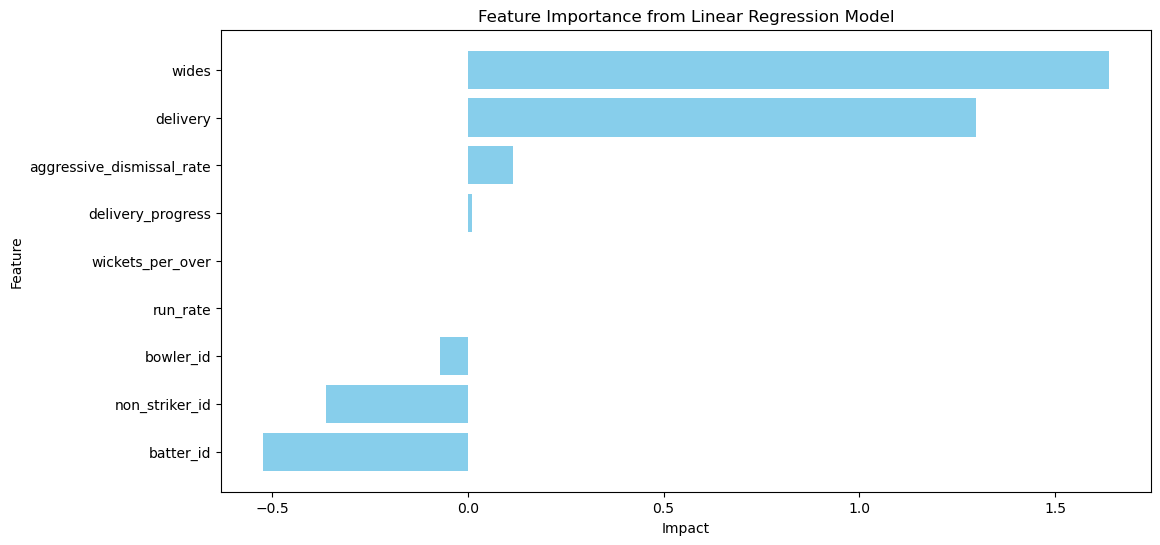

In [211]:
# Calculating feature importance from the linear regression model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.coef_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Impact')
plt.ylabel('Feature')
plt.title('Feature Importance from Linear Regression Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

Introducing gradient boosting regression decreases the errors even more.

In [212]:
from sklearn.ensemble import GradientBoostingRegressor

# Initializing the Gradient Boosting model with default parameters
gbr_model = GradientBoostingRegressor(random_state=42)

# Training the Gradient Boosting model on the extended feature set
gbr_model.fit(X_train, y_train)

# Making predictions on the test set with the Gradient Boosting model
y_pred_gbr = gbr_model.predict(X_test)

# Calculating evaluation metrics for the Gradient Boosting model
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

mae_gbr, rmse_gbr


(2.2199111915468857, 2.808039367022608)

Optimising the hyperparameters.

In [213]:
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initializing the GridSearchCV with GradientBoostingRegressor and the parameter grid
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, 
                           scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

# Fitting GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Extracting the best model and its performance metrics
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Calculating evaluation metrics for the best model found by GridSearchCV
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

grid_search.best_params_, mae_best, rmse_best


({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150},
 1.9972503194717004,
 2.935303310322699)

I now create a visualisation of the success of the model.

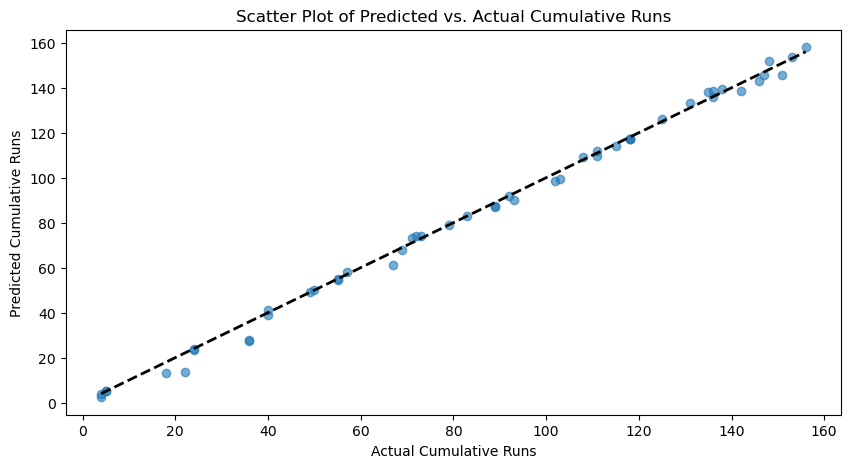

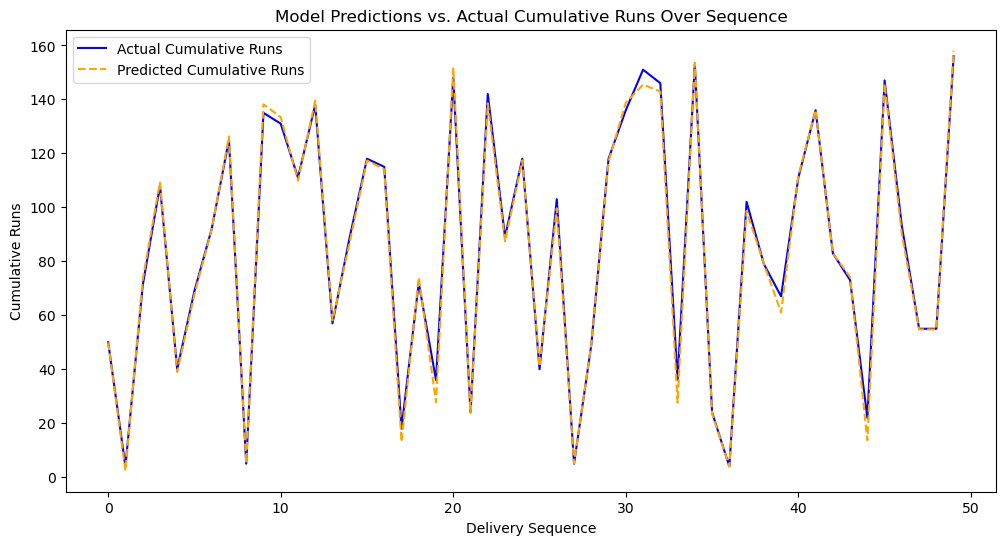

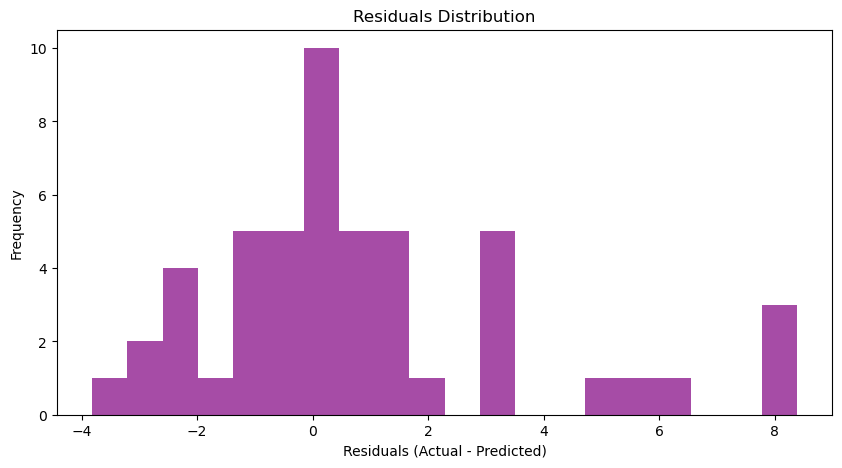

In [214]:
import matplotlib.pyplot as plt

# Assuming we have model predictions and ground truth labels for the test set
y_test = y_test.reset_index(drop=True)  # Reset index for alignment
y_pred_best = pd.Series(y_pred_best)    # Convert predictions to Series for easier handling

# 1. Scatter Plot of Predicted vs Actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Cumulative Runs')
plt.ylabel('Predicted Cumulative Runs')
plt.title('Scatter Plot of Predicted vs. Actual Cumulative Runs')
plt.show()

# 2. Line Plot of Predictions and Actuals Over Sequence
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Cumulative Runs', color='blue')
plt.plot(y_pred_best, label='Predicted Cumulative Runs', color='orange', linestyle='--')
plt.xlabel('Delivery Sequence')
plt.ylabel('Cumulative Runs')
plt.title('Model Predictions vs. Actual Cumulative Runs Over Sequence')
plt.legend()
plt.show()

# 3. Residual Plot (Difference between Predictions and Actuals)
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20, alpha=0.7, color='purple')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


A rough guide to a player ratings model.

In [215]:
# Define example weights for batting and bowling metrics
weights = {
    "runs": 1,               # Base weight per run scored
    "boundaries": 1.5,       # Additional weight for boundaries (4s and 6s)
    "strike_rate": 2,        # Weight for strike rate
    "wickets": 25,           # High weight for wickets as a primary bowling outcome
    "economy": 0.5,          # Penalty weight for economy rate (runs conceded per over)
    "maidens": 10            # Reward weight for maidens
}
# Prepare the dataset by calculating batting and bowling relevant metrics for each player

# Filter only valid deliveries to calculate accurate metrics
valid_deliveries = df[df['runs_batter'] >= 0]

# Calculate runs scored and boundaries
batter_stats = valid_deliveries.groupby('batter_id').agg(
    runs_scored=('runs_batter', 'sum'),
    balls_faced=('delivery', 'count'),
    boundaries=('runs_batter', lambda x: (x == 4).sum() + (x == 6).sum())  # Count 4s and 6s as boundaries
).reset_index()

# Calculate strike rate (runs per 100 balls faced)
batter_stats['strike_rate'] = (batter_stats['runs_scored'] / batter_stats['balls_faced']) * 100

# Calculate weighted batting score
batter_stats['batting_score'] = (
    (batter_stats['runs_scored'] * weights['runs']) +
    (batter_stats['boundaries'] * weights['boundaries']) +
    (batter_stats['strike_rate'] * weights['strike_rate'])
)

# Calculate bowling statistics
bowler_stats = valid_deliveries.groupby('bowler_id').agg(
    runs_conceded=('runs_total', 'sum'),
    balls_bowled=('delivery', 'count'),
    wickets=('is_wicket', 'sum'),
    maidens=('runs_total', lambda x: (x == 0).sum() // 6)  # Assuming maidens are full overs without runs
).reset_index()

# Calculate economy rate (runs per over)
bowler_stats['economy_rate'] = bowler_stats['runs_conceded'] / (bowler_stats['balls_bowled'] / 6)

# Calculate weighted bowling score
bowler_stats['bowling_score'] = (
    (bowler_stats['wickets'] * weights['wickets']) -
    (bowler_stats['economy_rate'] * weights['economy']) +
    (bowler_stats['maidens'] * weights['maidens'])
)

# Merge batting and bowling scores for a comprehensive player scoring summary
player_scores = pd.merge(batter_stats[['batter_id', 'batting_score']], 
                         bowler_stats[['bowler_id', 'bowling_score']], 
                         left_on='batter_id', right_on='bowler_id', 
                         how='outer').fillna(0)

# Rename columns for clarity
player_scores = player_scores.rename(columns={'batter_id': 'player_id'})
player_scores = player_scores[['player_id', 'batting_score', 'bowling_score']]

# Get a list of all unique player IDs from both batting and bowling datasets
all_player_ids = pd.Series(pd.concat([batter_stats['batter_id'], bowler_stats['bowler_id']])).unique()

# Initialize a DataFrame with all player IDs
all_players_df = pd.DataFrame(all_player_ids, columns=['player_id']).astype(int)

# Merge batting and bowling scores onto the full list of player IDs
player_scores_complete = all_players_df.merge(
    batter_stats[['batter_id', 'batting_score']], left_on='player_id', right_on='batter_id', how='left'
).merge(
    bowler_stats[['bowler_id', 'bowling_score']], left_on='player_id', right_on='bowler_id', how='left'
).fillna(0)

# Drop redundant columns and ensure integer IDs
player_scores_complete = player_scores_complete[['player_id', 'batting_score', 'bowling_score']].astype({'player_id': int})

# Reverse the player mapping to get player names from player_id
reverse_player_mapping = {v: k for k, v in player_mapping.items()}

player_scores_complete['player_name'] = player_scores_complete['player_id'].map(reverse_player_mapping)

player_scores_complete

,player_id,batting_score,bowling_score,player_name
0,1,348.296296,0.000000,CH Gayle
1,2,211.500000,-3.750000,J Allenby
2,3,446.571429,0.000000,PD Trego
3,4,255.571429,0.000000,DPMD Jayawardene
4,5,153.454545,-6.000000,JG Myburgh
5,6,354.571429,20.750000,L Gregory
6,7,297.923077,83.080000,RE van der Merwe
7,8,0.000000,0.000000,HJH Marshall
8,9,220.666667,0.000000,IA Cockbain
9,10,343.227273,0.000000,M Klinger


Real MOTM was M Klinger, possibly due to reasons other than batting display - overcame external factors, fielding performance etc.

To further investigate this cricket match, we can consider different phases of the game, and the impact of certain features.

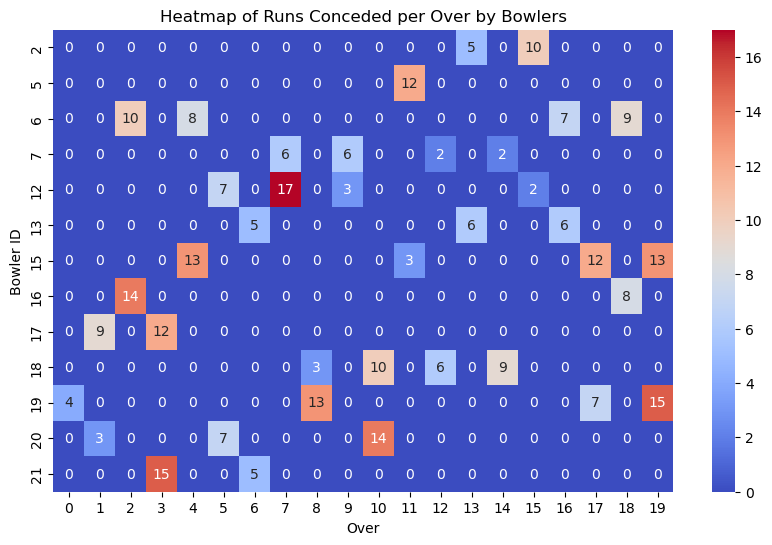

In [229]:
heatmap_data_runs = df.pivot_table(index='bowler_id', columns='over', values='runs_total', aggfunc='sum').fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_runs, annot=True, cmap="coolwarm")
plt.title("Heatmap of Runs Conceded per Over by Bowlers")
plt.xlabel("Over")
plt.ylabel("Bowler ID")
plt.show()

Now look at different phases of the match, namely death overs, powerplay and periods where the required run rate is greater than the average run rate so far.

In [218]:
death_overs_batting = df[df['over'] >= 16].groupby('batter_id').agg(
    runs_scored=('runs_batter', 'sum'),
    deliveries_faced=('delivery', 'count'),
    wickets_lost=('is_wicket', 'sum')
).reset_index()


powerplay_bowling = df[df['over'] <= 6].groupby('bowler_id').agg(
    runs_conceded=('runs_total', 'sum'),
    wickets_taken=('is_wicket', 'sum'),
    overs_bowled=('delivery', lambda x: x.nunique() / 6) 
).reset_index()


average_run_rate = df['run_rate'].mean()
high_pressure_bowling = df[df['run_rate'] > average_run_rate].groupby('bowler_id').agg(
    runs_conceded=('runs_total', 'sum'),
    wickets_taken=('is_wicket', 'sum')
).reset_index()

death_overs_batting, powerplay_bowling, high_pressure_bowling

(   batter_id  runs_scored  deliveries_faced  wickets_lost
 0          6           22                13             0
 1          7           17                11             0
 2         10            5                 3             1
 3         14           12                 9             0
 4         15           18                11             0,
    bowler_id  runs_conceded  wickets_taken  overs_bowled
 0          6             18              0      2.000000
 1         12              7              0      1.166667
 2         13              5              1      1.166667
 3         15             13              0      1.000000
 4         16             14              0      2.000000
 5         17             21              0      2.000000
 6         19              4              1      1.500000
 7         20             10              1      2.000000
 8         21             20              0      2.000000,
    bowler_id  runs_conceded  wickets_taken
 0         19       

The first table evaluates batters' performance in the final overs (16-20), typically high-pressure situations where quick runs are needed:

Batter ID 6 scored the highest runs (22) off 13 deliveries without losing their wicket, showcasing effective power-hitting under pressure.\
Batter ID 15 scored 18 runs off 11 deliveries without being dismissed, indicating strong contributions.\
Batter ID 10 struggled, managing only 5 runs off 3 deliveries and losing a wicket, which might have impacted their team's ability to finish strongly.

The second table shows how bowlers performed during the first 6 overs of the match, where restrictions on fielders make it easier for batters to score:

Bowler ID 13 performed well, conceding only 5 runs and taking 1 wicket in approximately 1.2 overs, showcasing accuracy and wicket-taking ability.\
Bowler ID 17 conceded the most runs (21) in 2 overs without taking any wickets, indicating inefficiency during the powerplay.\
Bowler ID 19 was economical, conceding just 4 runs and taking 1 wicket in 1.5 overs, which would have been valuable for their team.

The final table focuses on bowlers' performance when the required run rate is higher than the match's average, indicating intense pressure to defend runs:

Bowler ID 19 was the only bowler highlighted, conceding 4 runs without taking a wicket. While economical, their inability to take wickets in such a situation may have limited their impact.

## Conclusion and Further Improvements

Data for the T20 cricket match between Gloucestershire and Somerset Men's was parsed, cleaned, and analysed to investigate innings data. A simple linear regression predictive model was fit to the data to investigate its suitability and error. Important features were recongised. A more sophisticated model in the gradient boosting regressor was used to try and decrease the error. The hyperparameters were tuned using a grid search. This data was then explored further to give individual player ratings and player performace during specific game phases. 

This project could be extended by incorporating more games into this dataset. This would allow for the model to do better at predicting the outcome of each game (W,L,D), ultimately providing more scope for an insightful real-time probability prediction. 

I would like to thank you, Hawkeye, for the opportunity to complete this project as part of your recruitment process, regardless of the outcome. I am an applied mathematician by training and relatively new to data science so I hope you will also consider the other skills that I can bring to the team. I am a passionate sports fan, numerically proficient and academically successful - looking to bring my enthusiasm and skills to your team due to our shared interests!

